In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ( precision_score, recall_score, f1_score,
                              roc_auc_score, average_precision_score, confusion_matrix)



gmm = pd.read_csv("../outputs/gmm_predictions.csv")
dbscan = pd.read_csv("../outputs/dbscan_predictions.csv")
ae = pd.read_csv("../outputs/autoencoder_predictions.csv")

# ground truth
y_test = pd.read_csv("../data/processed/y_test.csv")
ids_test = pd.read_csv("../data/processed/ids_test.csv")


In [12]:
def evaluate_model(pred_df, y_df, model_name):

    df = pred_df.merge(y_df, on="id", how="inner")
    y_true = df["Class"].astype(int)
    y_pred = df["is_anomaly"].astype(int)
    y_score = df["anomaly_score"].astype(float)

    return {
        "Modelo": model_name,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_score),
        "PR-AUC": average_precision_score(y_true, y_score),
        "TN_FP_FN_TP": confusion_matrix(y_true, y_pred).ravel().tolist()
    }


In [13]:
results = []

results.append(evaluate_model(gmm, y_test, "GMM"))
results.append(evaluate_model(dbscan, y_test, "DBSCAN"))
results.append(evaluate_model(ae, y_test, "Autoencoder"))

results_df = pd.DataFrame(results)
results_df


,Modelo,Precision,Recall,F1-score,ROC-AUC,PR-AUC,TN_FP_FN_TP
0,GMM,0.536364,0.797297,0.641304,0.940720,0.767685,"[42597, 51, 15, 59]"
1,DBSCAN,0.080790,0.608108,0.142631,0.798051,0.049808,"[42136, 512, 29, 45]"
2,Autoencoder,0.065996,0.797297,0.121901,0.943545,0.161660,"[41813, 835, 15, 59]"


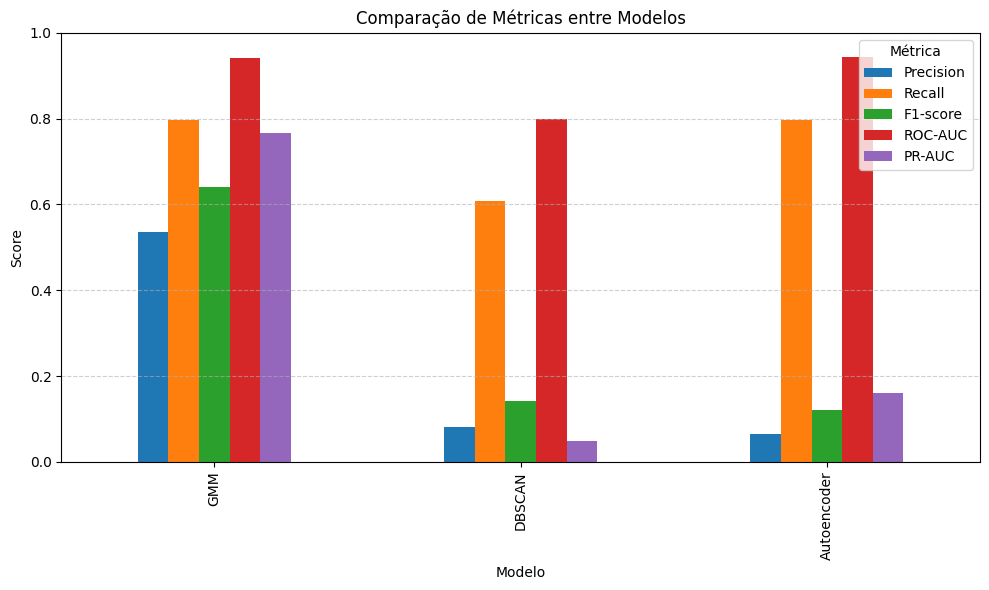

In [14]:
metrics_to_plot = ["Precision", "Recall", "F1-score", "ROC-AUC", "PR-AUC"]

results_df.set_index("Modelo")[metrics_to_plot].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Métrica")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Análise e Comparação de Resultados

### Justificativa das Métricas Utilizadas

O problema abordado neste projeto consiste na detecção de transações fraudulentas,
caracterizando um cenário de **classes extremamente desbalanceadas**, no qual as fraudes representam uma pequena fração do total de observações. Nesses casos,
métricas tradicionais como a acurácia tornam-se inadequadas, pois podem apresentar
valores elevados mesmo quando o modelo falha em identificar as fraudes.

Por isso, as métricas escolhidas são apropriadas:

- Recall: mede quantas fraudes reais foram encontradas. Valores baixos significam que muitas fraudes passam despercebidas.

- Precision: mede quão confiáveis são os alertas de fraude (qualidade). Valores baixos indicam muitos falsos positivos, aumentando o custo operacional.

- F1-score: é a média harmônica entre Precision e Recall, fornecendo uma medida de equilíbrio entre a capacidade de detecção e a confiabilidade dos alertas.

- ROC-AUC: avalia a separabilidade global entre classes usando o anomaly_score (independente do limiar).

- PR-AUC: é particularmente adequada para dados desbalanceados, pois foca no desempenho do modelo sobre a classe positiva, evidenciando o trade-off entre Precision e Recall ao variar o limiar.

- TN, FP, FN, TP: traduz os resultados em números concretos de erros e acertos, permitindo interpretar impacto prático: falsos alarmes (FP) e fraudes perdidas (FN).

Em conjunto, essas métricas
permitem avaliar tanto a capacidade de detecção de fraudes quanto a confiabilidade dos
alertas gerados e a qualidade do score contínuo produzido pelos modelos.


### GMM

O modelo baseado em Gaussian Mixture Models apresentou **Recall elevado (~80%)**,
detectando a maior parte das fraudes, ao mesmo tempo em que manteve um número muito
baixo de falsos positivos. A **Precision superior a 50%** indica que mais da metade
dos alertas gerados correspondem a fraudes reais, o que representa um bom resultado operacional para um problema de classe rara.

O **F1-score elevado** confirma o bom equilíbrio entre detecção e confiabilidade, e os
valores altos de **ROC-AUC** e **PR-AUC** indicam que o score do modelo possui elevada
capacidade discriminativa, tanto em termos globais quanto especificamente para a
classe fraudulenta.


### DBSCAN

O DBSCAN apresentou desempenho inferior em praticamente todas as métricas. Embora
tenha conseguido identificar parte das fraudes, seu **Recall foi moderado, mas significativamente menor** que o dos demais modelos. Além disso, o elevado número de falsos positivos resultou em **Precision muito baixa**, tornando os alertas pouco confiáveis.

O **F1-score reduzido** reflete o fraco equilíbrio entre Precision e Recall, enquanto
os valores mais baixos de **ROC-AUC** e **PR-AUC** indicam limitada capacidade de
separação entre transações normais e fraudulentas. Esses resultados sugerem que, na
configuração utilizada, o DBSCAN não é adequado para o problema em questão.

Detecta parte das fraudes, mas com muitos falsos alarmes e baixa confiabilidade dos alertas.


### Autoencoder

O Autoencoder apresentou **Recall elevado**, equivalente ao do GMM, indicando boa
capacidade de detecção de fraudes. Além disso, o valor alto de **ROC-AUC** demonstra
excelente separação global entre as classes a partir do score de anomalia.

Entretanto, o modelo gerou
um número muito elevado de falsos positivos, resultando em **Precision bastante
reduzida** e, consequentemente, em um **F1-score baixo**. O valor intermediário de
**PR-AUC** reforça que, embora o score seja informativo, o limiar adotado para definir
anomalias é excessivamente permissivo, indicando a necessidade de ajuste de threshold
para uso prático.

### Comparação Entre os Modelos

O **GMM** destaca-se como o modelo mais equilibrado, combinando alta taxa de detecção de fraudes, baixo número de falsos positivos e excelente desempenho tanto em ROC-AUC quanto em
PR-AUC. O **Autoencoder** mostra-se promissor em termos de separação global, mas
operacionalmente inviável sem ajustes adicionais no critério de decisão. O **DBSCAN**
apresenta desempenho inferior, com menor capacidade de detecção e alto custo
operacional devido à grande quantidade de falsos alarmes.

Os resultados piores significam que DBSCAN e Autoencoder “são ruins”? Não, significam que eles são menos adequados para este dataset específico e para esta configuração.

O Credit Card Fraud Dataset tem características muito específicas:

- variáveis V1–V28 já transformadas por PCA
- baixa correlação linear entre atributos
- fraudes não formam clusters compactos
- forte sobreposição entre classes em várias dimensões

**Esses pontos favorecem alguns modelos e penalizam outros.**

GMM funciona especialmente bem quando as variáveis tem baixa correlação, as distribuições são aproximadamente elípticas e os dados estão em um espaço “bem comportado”, exatamente o que PCA produz. Logo, esse modelo consegue estimar bem médias e covariâncias, modelar a distribuição dos dados normais e identificar anomalias como observações de baixa probabilidade.

Já o DBSCAN é um algoritmo baseado em densidade, assumindo que os dados formam regiões densas bem definidas, enquanto anomalias aparecem em áreas de baixa densidade. No entanto, em espaços de alta dimensão, justamente como o espaço PCA com 28 variáveis,  a noção de densidade se degrada significativamente devido ao curse of dimensionality, fazendo com que as distâncias entre pontos se tornem mais homogêneas e os clusters menos compactos. Além disso, no conjunto de dados analisado, as transações fraudulentas não formam agrupamentos claramente separados, encontrando-se dispersas ao longo do espaço de atributos. Como consequência, o DBSCAN tende a classificar muitos pontos normais como ruído (resultando em elevado número de falsos positivos) e ainda perde parte das fraudes reais, refletindo-se em baixa Precision, PR-AUC reduzida e fraco desempenho operacional.

O Autoencoder apresentou resultados mistos devido ao seu alinhamento apenas intermediário com a estrutura dos dados. Autoencoders aprendem padrões por meio de compressão e reconstrução, sendo particularmente eficazes quando os dados apresentam dependências não lineares e estruturas correlacionadas que podem ser exploradas durante o processo de codificação. Entretanto, a aplicação prévia de PCA remove correlações lineares entre as variáveis e reduz redundâncias, tornando o espaço de atributos mais desacoplado e limitando o potencial de aprendizado do autoencoder. Ainda assim, o modelo demonstrou excelente capacidade de separação global entre transações normais e fraudulentas, evidenciada pelo alto valor de ROC-AUC.


### Conclusão

Considerando simultaneamente a capacidade de identificar fraudes, a confiabilidade dos
alertas e a separação entre as classes, o **GMM** apresenta o melhor desempenho geral
no cenário avaliado. O Autoencoder surge como uma alternativa potencialmente eficaz,
desde que seja realizado um ajuste adequado do limiar de decisão. Já o DBSCAN, na
configuração atual, mostrou-se menos apropriado para a tarefa de detecção de fraudes.
